In [1]:
import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
stop_words = set(stopwords.words('spanish'))
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns


In [2]:
#Cargar dataset de entrenamientos(cartas de solicitudes del alumno)
train_rt = pd.read_csv('dataset/dataset_rt_20082018.csv', encoding = "ISO-8859-1", sep=';')

In [3]:
train_rt.head()

,WOSOCO_C_WORK_PARA_VALO,WOPAVA_VALOR,WOSOCO_VALOR
0,1,Salud estudiante,Jueves 1 de Marzo 2018/Valparaíso\r\n\r\nSra. ...
1,1,Salud estudiante,Sra. Directora de Procesos Docentes Angélica C...
2,11,Sin expresión de causa,"Dentro de mi grupo familiar, se encuentra mi m..."
3,6,Vocacional,"Sra. Angélica Casaletti Logola, \r\nDirectora ..."
4,5,Cambio socioeconómico,Santiago 1 de Marzo de 2018\r\nSeñores \r\nPon...


In [4]:
#numero de palabras
train_rt['word_count'] = train_rt['WOSOCO_VALOR'].apply(lambda x: len(str(x).split(" ")))
train_rt[['WOSOCO_VALOR','word_count']].head()

,WOSOCO_VALOR,word_count
0,Jueves 1 de Marzo 2018/Valparaíso\r\n\r\nSra. ...,90
1,Sra. Directora de Procesos Docentes Angélica C...,102
2,"Dentro de mi grupo familiar, se encuentra mi m...",184
3,"Sra. Angélica Casaletti Logola, \r\nDirectora ...",162
4,Santiago 1 de Marzo de 2018\r\nSeñores \r\nPon...,143


In [5]:
#contar caracteres

train_rt['char_count'] = train_rt['WOSOCO_VALOR'].str.len()
train_rt[['WOSOCO_VALOR','char_count']].head()

,WOSOCO_VALOR,char_count
0,Jueves 1 de Marzo 2018/Valparaíso\r\n\r\nSra. ...,620.0
1,Sra. Directora de Procesos Docentes Angélica C...,671.0
2,"Dentro de mi grupo familiar, se encuentra mi m...",1000.0
3,"Sra. Angélica Casaletti Logola, \r\nDirectora ...",1000.0
4,Santiago 1 de Marzo de 2018\r\nSeñores \r\nPon...,1000.0


In [6]:
#Mostrar datos nulos

null_train_rt = train_rt[train_rt.isnull().any(axis=1)]
null_train_rt.head()

,WOSOCO_C_WORK_PARA_VALO,WOPAVA_VALOR,WOSOCO_VALOR,word_count,char_count
8,7,Cambio carrera (interno),NaN,1,NaN
24,4,Cuidado hijo,NaN,1,NaN
170,1,Salud estudiante,NaN,1,NaN
206,7,Cambio carrera (interno),NaN,1,NaN
219,1,Salud estudiante,NaN,1,NaN


In [7]:
#Se eliminan los datos nulos
train_rt = train_rt.dropna()
train_rt.shape

(880, 5)

In [8]:
train_rt.isnull().sum()

WOSOCO_C_WORK_PARA_VALO    0
WOPAVA_VALOR               0
WOSOCO_VALOR               0
word_count                 0
char_count                 0
dtype: int64

In [9]:
# se identifican los stopwords

train_rt['stopwords'] = train_rt['WOSOCO_VALOR'].apply(lambda x: len([x for x in x.split() if x in stop_words]))
train_rt[['WOSOCO_VALOR','stopwords']].head()

,WOSOCO_VALOR,stopwords
0,Jueves 1 de Marzo 2018/Valparaíso\r\n\r\nSra. ...,31
1,Sra. Directora de Procesos Docentes Angélica C...,43
2,"Dentro de mi grupo familiar, se encuentra mi m...",92
3,"Sra. Angélica Casaletti Logola, \r\nDirectora ...",75
4,Santiago 1 de Marzo de 2018\r\nSeñores \r\nPon...,50


In [10]:
train_rt['WOSOCO_VALOR'].isnull().sum()

0

In [11]:
#se identifican los valores numericos

train_rt['numerics'] = train_rt['WOSOCO_VALOR'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
train_rt[['WOSOCO_VALOR','numerics']].head()

,WOSOCO_VALOR,numerics
0,Jueves 1 de Marzo 2018/Valparaíso\r\n\r\nSra. ...,1
1,Sra. Directora de Procesos Docentes Angélica C...,1
2,"Dentro de mi grupo familiar, se encuentra mi m...",0
3,"Sra. Angélica Casaletti Logola, \r\nDirectora ...",0
4,Santiago 1 de Marzo de 2018\r\nSeñores \r\nPon...,2


In [12]:
#se Cuentan las palabras en minusculas
train_rt['upper'] = train_rt['WOSOCO_VALOR'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
train_rt[['WOSOCO_VALOR','upper']].head()

,WOSOCO_VALOR,upper
0,Jueves 1 de Marzo 2018/Valparaíso\r\n\r\nSra. ...,9
1,Sra. Directora de Procesos Docentes Angélica C...,0
2,"Dentro de mi grupo familiar, se encuentra mi m...",0
3,"Sra. Angélica Casaletti Logola, \r\nDirectora ...",0
4,Santiago 1 de Marzo de 2018\r\nSeñores \r\nPon...,16


In [13]:
#Otro paso de preprocesamiento es dejar todo el documento en minúsculas.

train_rt['WOSOCO_VALOR'] = train_rt['WOSOCO_VALOR'].apply(lambda x: " ".join(x.lower() for x in x.split()))
train_rt['WOSOCO_VALOR'].head()

0    jueves 1 de marzo 2018/valparaíso sra. angelic...
1    sra. directora de procesos docentes angélica c...
2    dentro de mi grupo familiar, se encuentra mi m...
3    sra. angélica casaletti logola, directora de l...
4    santiago 1 de marzo de 2018 señores pontificia...
Name: WOSOCO_VALOR, dtype: object

In [14]:
#se valida nuevamente si quedan palabras en mayusculas

train_rt['upper'] = train_rt['WOSOCO_VALOR'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
train_rt[['WOSOCO_VALOR','upper']].head()

,WOSOCO_VALOR,upper
0,jueves 1 de marzo 2018/valparaíso sra. angelic...,0
1,sra. directora de procesos docentes angélica c...,0
2,"dentro de mi grupo familiar, se encuentra mi m...",0
3,"sra. angélica casaletti logola, directora de l...",0
4,santiago 1 de marzo de 2018 señores pontificia...,0


In [15]:
#Eliminar la puntuación#
#El siguiente paso es eliminar la puntuación, ya que no agrega ninguna información adicional al tratar los datos de texto.
# Por lo tanto, eliminar todas las instancias de este nos ayudará a reducir el tamaño de los datos de entrenamiento.#

train_rt['WOSOCO_VALOR'] = train_rt['WOSOCO_VALOR'].str.replace('[^\w\s]','')
train_rt['WOSOCO_VALOR'].head()


0    jueves 1 de marzo 2018valparaíso sra angelica ...
1    sra directora de procesos docentes angélica ca...
2    dentro de mi grupo familiar se encuentra mi ma...
3    sra angélica casaletti logola directora de la ...
4    santiago 1 de marzo de 2018 señores pontificia...
Name: WOSOCO_VALOR, dtype: object

In [16]:
#Eliminación de palabras de alto#
#Como mencionamos anteriormente, las palabras de detención (o las palabras que ocurren comúnmente)#
#deben eliminarse de los datos de texto. Para este propósito, podemos crear una lista de palabras vacías o# 
#podemos usar bibliotecas predefinidas.#

train_rt['WOSOCO_VALOR'] = train_rt['WOSOCO_VALOR'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))
train_rt['WOSOCO_VALOR'].head()

0    jueves 1 marzo 2018valparaíso sra angelica cas...
1    sra directora procesos docentes angélica casal...
2    dentro grupo familiar encuentra madre pasando ...
3    sra angélica casaletti logola directora direcc...
4    santiago 1 marzo 2018 señores pontificia unive...
Name: WOSOCO_VALOR, dtype: object

In [17]:
#Eliminación común de palabras#
#Previamente, simplemente eliminamos las palabras que ocurren comúnmente en un sentido general. 
#revisemos las 10 palabras más frecuentes en nuestros datos de texto
freq = pd.Series(' '.join(train_rt['WOSOCO_VALOR']).split()).value_counts()[:10]
print(freq)

carrera        1135
semestre        855
retiro          845
año             701
total           662
universidad     600
poder           454
debido          444
asignaturas     410
situación       363
dtype: int64


In [18]:
#Ahora, se eliminan estas palabras ya que su presencia no será de ninguna utilidad 
#en la clasificación de nuestros datos de texto.#
freq = list(freq.index)
train_rt['WOSOCO_VALOR'] = train_rt['WOSOCO_VALOR'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
train_rt['WOSOCO_VALOR'].head()

0    jueves 1 marzo 2018valparaíso sra angelica cas...
1    sra directora procesos docentes angélica casal...
2    dentro grupo familiar encuentra madre pasando ...
3    sra angélica casaletti logola directora direcc...
4    santiago 1 marzo 2018 señores pontificia catól...
Name: WOSOCO_VALOR, dtype: object

In [19]:
#Se muestran las 10 palabras menos utilizadas
freq = pd.Series(' '.join(train_rt['WOSOCO_VALOR']).split()).value_counts()[-10:]
print(freq)

requerimientos    1
evidente          1
notablemente      1
dañará            1
abra              1
terapéutico       1
expectativa       1
carvallo          1
asistencias       1
examinar          1
dtype: int64


In [20]:
#Se eliminan las palabras menos utilizadas
freq = list(freq.index)
train_rt['WOSOCO_VALOR'] = train_rt['WOSOCO_VALOR'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
train_rt['WOSOCO_VALOR'].head()

0    jueves 1 marzo 2018valparaíso sra angelica cas...
1    sra directora procesos docentes angélica casal...
2    dentro grupo familiar encuentra madre pasando ...
3    sra angélica casaletti logola directora direcc...
4    santiago 1 marzo 2018 señores pontificia catól...
Name: WOSOCO_VALOR, dtype: object

In [21]:
#Se eliminan los valores numericos

train_rt['WOSOCO_VALOR'] = train_rt['WOSOCO_VALOR'].apply(lambda x: " ".join(x for x in x.split() if not x.isdigit()))
train_rt['WOSOCO_VALOR'].head()

0    jueves marzo 2018valparaíso sra angelica casal...
1    sra directora procesos docentes angélica casal...
2    dentro grupo familiar encuentra madre pasando ...
3    sra angélica casaletti logola directora direcc...
4    santiago marzo señores pontificia católica val...
Name: WOSOCO_VALOR, dtype: object

In [22]:
train =  train_rt.drop(['char_count', 'stopwords','numerics','upper','word_count'], axis=1)
counts = []
categories = ['salud estudiante','salud familiar','fallecimiento','cuidado hijo', 'cambio socioeconomico', 'vacacional',
  'cambio carrera', 'traslado alumno','prblemas legales', 'problemas familiares', 'sin expresion causa','otra causa']

train.WOSOCO_C_WORK_PARA_VALO.replace((1,2,3,4,5,6,7,8,9,10,11,12),
  ('salud estudiante','salud familiar','fallecimiento','cuidado hijo', 'cambio socioeconomico', 'vacacional',
  'cambio carrera', 'traslado alumno','prblemas legales', 'problemas familiares', 'sin expresion causa','otra causa'), inplace =True)


suma =train.groupby('WOSOCO_C_WORK_PARA_VALO').size()

p_df = pd.DataFrame({"Cantidad": suma})
p_df.head()


,Cantidad
WOSOCO_C_WORK_PARA_VALO,
cambio carrera,23
cambio socioeconomico,35
cuidado hijo,9
fallecimiento,8
otra causa,131


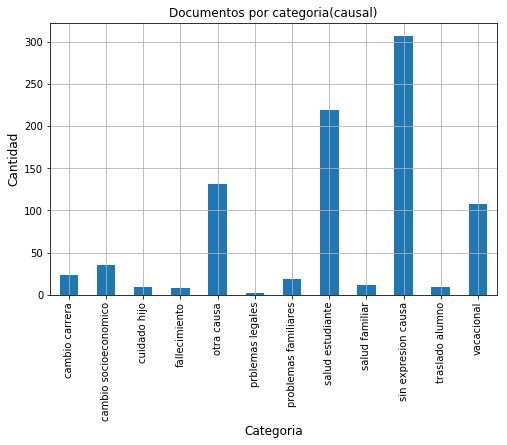

In [23]:
p_df.plot(kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Documentos por categoria(causal)")
plt.ylabel('Cantidad', fontsize=12)
plt.xlabel('Categoria', fontsize=12)
plt.show()

In [24]:
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

# This code was tested with TensorFlow v1.4
print("You have TensorFlow version", tf.__version__)

C:\Users\jose\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


You have TensorFlow version 1.8.0


In [25]:
train_rt.WOSOCO_C_WORK_PARA_VALO.replace((1,2,3,4,5,6,7,8,9,10,11,12),
  ('Salud estudiante','Salud familiar','Fallecimiento','Cuidado hijo', 'Cambio socioeconómico', 'Vocacional',
  'Cambio Carrera', 'Traslado alumno','Problemas legales', 'Problemas familiares', 'Sin expresión causa','Otra causa'), inplace =True)


In [26]:
train_rt.head()

,WOSOCO_C_WORK_PARA_VALO,WOPAVA_VALOR,WOSOCO_VALOR,word_count,char_count,stopwords,numerics,upper
0,Salud estudiante,Salud estudiante,jueves marzo 2018valparaíso sra angelica casal...,90,620.0,31,1,0
1,Salud estudiante,Salud estudiante,sra directora procesos docentes angélica casal...,102,671.0,43,1,0
2,Sin expresión causa,Sin expresión de causa,dentro grupo familiar encuentra madre pasando ...,184,1000.0,92,0,0
3,Vocacional,Vocacional,sra angélica casaletti logola directora direcc...,162,1000.0,75,0,0
4,Cambio socioeconómico,Cambio socioeconómico,santiago marzo señores pontificia católica val...,143,1000.0,50,2,0


In [27]:
train_rt['WOSOCO_C_WORK_PARA_VALO'].value_counts()

Sin expresión causa      307
Salud estudiante         219
Otra causa               131
Vocacional               107
Cambio socioeconómico     35
Cambio Carrera            23
Problemas familiares      18
Salud familiar            12
Traslado alumno            9
Cuidado hijo               9
Fallecimiento              8
Problemas legales          2
Name: WOSOCO_C_WORK_PARA_VALO, dtype: int64

In [28]:
# Split data into train and test
train_size = int(len(train_rt) * .8)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(train_rt) - train_size))

Train size: 704
Test size: 176


In [29]:
train_letter = train_rt['WOSOCO_VALOR'][:train_size]
train_category = train_rt['WOSOCO_C_WORK_PARA_VALO'][:train_size]

test_letter = train_rt['WOSOCO_VALOR'][train_size:]
test_category = train_rt['WOSOCO_C_WORK_PARA_VALO'][train_size:]

In [30]:

max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)


In [31]:
#Esta clase permite vectorizar un corpus de texto, convirtiendo cada texto en una secuencia de enteros(
#cada entero es el indice de un token en un diccionario)
#o en un vector donde el coeficiente para cada token podria ser binario, basado en tf-idf

tokenize.fit_on_texts(train_letter) 
x_train = tokenize.texts_to_matrix(train_letter)
x_test = tokenize.texts_to_matrix(test_letter)
print(x_train)

[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [32]:
# Se usa la utilidad sklearn para convertir la etiqueta de strings a un indice numerado
encoder = LabelEncoder()
encoder.fit(train_category)
y_train =  encoder.transform(train_category)
y_test = encoder.transform(test_category)
y_train_dos =  encoder.transform(train_category)
y_test_dos = encoder.transform(test_category)
print(y_train)

[ 7  7  9 11  1  4  4  4  7  1 10 11  4  4  2  5  7  7 11  1  4  9  4  7
 11 11  1  3  9  9  7 11  4  4  4  9  4  7 11  4  4  4  4  9  4  7 11  7
 11 11 11 11 11 11 11  4  7  4  0  7 11  7  4  4 11  7  9 11  7 11 11 11
 11  9 11 11 11 11 11  4  7 11 11  7  2  9  7  4 11 11  2  7 11  7  7  7
  3 11  7 11  7  4  4  9 11  7 11 11  1  4 11  0  1 11 11 11  4 11  9  9
  4 11  0  9  7  0  7 11  0 11  9  1 11  7  4  1  7 11 11  1 11  4  9 11
  7  7 11  9  0  0  9  4  7  9  7 11  7  9  4  9  4  0 11  1  7 11  4  9
  7  4 11  9  1 11  7  9  7  4  9  7  7  4  7  7 11  7  9 11  7  7 11  9
  9  7  7  7  7  1  7  7  7 11  1  4  4 11  9  9  4  9 11  4 11  1  7  9
  7  4  7  7  3  7  1  0  5  9  7  7  7  7  0  7  7  7  0 10  7  7  9  7
  4  9  4  4  4  9  0  4 11  9  7  0  9  9  9  7  7  7  0  9  7  1  9  1
  1  9  7  5 10  4  9 11  8  9 11  0  4  7  7  9  2  9  0 11  7  9  9 11
 11  7  7  4  4  4  4  5  1  0  7 10  4  4  4 10  7  4  4  5  4  4  7  7
  7  9  9  9  9  4  7  7  9  9  8  9  7  9  9  7  5

In [33]:
# Convierte las etiquetas en una representacion one-hot
num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

In [34]:
print(y_train)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [35]:
# Vemos como quedan los datos de entrenamiento y pruebas
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (704, 1000)
x_test shape: (176, 1000)
y_train shape: (704, 12)
y_test shape: (176, 12)


In [36]:
#Se crean los parametros de la red
batch_size = 32
epochs = 30

In [37]:
# Se construye el mdodelo
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [38]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 633 samples, validate on 71 samples
Epoch 1/30
633/633 [==============================] - 1s 886us/step - loss: 1.9818 - acc: 0.3428 - val_loss: 1.3633 - val_acc: 0.6056
Epoch 2/30
633/633 [==============================] - 0s 402us/step - loss: 1.2635 - acc: 0.6730 - val_loss: 1.2168 - val_acc: 0.5634
Epoch 3/30
633/633 [==============================] - 0s 408us/step - loss: 0.8897 - acc: 0.7978 - val_loss: 1.1013 - val_acc: 0.6056
Epoch 4/30
633/633 [==============================] - 0s 451us/step - loss: 0.6117 - acc: 0.8847 - val_loss: 1.0816 - val_acc: 0.5634
Epoch 5/30
633/633 [==============================] - 0s 509us/step - loss: 0.4382 - acc: 0.9131 - val_loss: 1.0735 - val_acc: 0.5634
Epoch 6/30
633/633 [==============================] - 0s 441us/step - loss: 0.3112 - acc: 0.9494 - val_loss: 1.0549 - val_acc: 0.5775
Epoch 7/30
633/633 [==============================] - 0s 418us/step - loss: 0.2472 - acc: 0.9589 - val_loss: 1.0655 - val_acc: 0.6761
Epoch 8/30
633/63

In [39]:
# Se avalua la precision de los datos de entrenamiento
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

176/176 [==============================] - 0s 108us/step
Test score: 1.5296421267769553
Test accuracy: 0.6534090909090909


In [40]:
# Aca se genera una prediccion individual en base a los datos de entrenamiento Vs los datos de pruebas
text_labels = encoder.classes_ 

for i in range(10):
    prediction = model.predict(np.array([x_test[i]]))
    predicted_label = text_labels[np.argmax(prediction)]
    print(test_letter.iloc[i][:50], "...")
    print('Etiqueta Actual:' , test_category.iloc[i])
    print("Etiqueta predicha: " , predicted_label , "\n")

 ...
Etiqueta Actual: Sin expresión causa
Etiqueta predicha:  Otra causa 

junto saludarles deseo solicitar corresponden peri ...
Etiqueta Actual: Sin expresión causa
Etiqueta predicha:  Sin expresión causa 

señor juan pablo herrera director interinodirecció ...
Etiqueta Actual: Sin expresión causa
Etiqueta predicha:  Otra causa 

través presente documento hago solicitud actualmen ...
Etiqueta Actual: Salud estudiante
Etiqueta predicha:  Salud estudiante 

solicito proseguir desvinculación persona instituc ...
Etiqueta Actual: Sin expresión causa
Etiqueta predicha:  Sin expresión causa 

valparaíso agosto sr juan pablo herrera carvajal d ...
Etiqueta Actual: Vocacional
Etiqueta predicha:  Otra causa 

estimado director procesos docentes escribo presen ...
Etiqueta Actual: Salud estudiante
Etiqueta predicha:  Salud estudiante 

estimado hago solicitud mal desempeño académico ob ...
Etiqueta Actual: Sin expresión causa
Etiqueta predicha:  Otra causa 

estimado señorseñora escribo carta 

In [41]:
#se guarda el modelo
model.save("modelo_red_neuronal.h5")